In [2]:
import numpy as np
from matplotlib import pyplot as plt
from math import floor, ceil # for rounding up and down
from scipy.stats import pearsonr
from sklearn import datasets
import pandas as pd
import math
from typing import Dict, Tuple, List

In [3]:
def Get_Class_Label_Of_Object(x):
    return x[len(x)-1]

def Distance(x, y):
    if len(x) != len(y):
        return -1
    
    sum = 0
    for i in range(len(x)):
        sum += (x[i]-y[i])*(x[i]-y[i])
        
    return sum

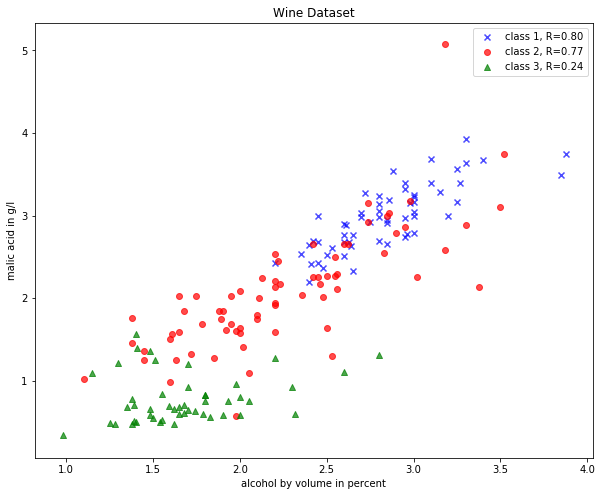

In [4]:
def PrepareData():
    all_data = np.loadtxt(open("./wine_data.csv","r"), delimiter = ",", skiprows = 0, dtype = np.float64)

    # load class labels from column 1
    y_wine = all_data[:,0]
    #print (y_wine)
    # conversion of the class labels to integer-type array
    y_wine = y_wine.astype(np.int64, copy = False)

    # load the 14 features
    X_wine = all_data[:,1:]
    
    data = all_data[:, 6:8]   #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 6:9    
    
    from scipy.stats import pearsonr

    plt.figure(figsize=(10,8))

    for label,marker,color in zip(
            range(1,4),('x', 'o', '^'),('blue', 'red', 'green')):

        # Calculate Pearson correlation coefficient
        R = pearsonr(data[:,0][y_wine == label], data[:,1][y_wine == label])
        plt.scatter(x=data[:,0][y_wine == label], # x-axis: feat. from col. 1
                    y=data[:,1][y_wine == label], # y-axis: feat. from col. 2
                    marker=marker, # data point symbol for the scatter plot
                    color=color,
                    alpha=0.7,
                    label='class {:}, R={:.2f}'.format(label, R[0]) # label for the legend
                    )

    plt.title('Wine Dataset')
    plt.xlabel('alcohol by volume in percent')
    plt.ylabel('malic acid in g/l')
    plt.legend(loc='upper right')

    plt.show()
    
    
    
    w, h = 3, len(data)
    m = [[0 for x in range(w)] for y in range(h)] 

    for i in range(len(data)):
        for j in range(2):
            m[i][j] = data[i, j]
        m[i][2] = y_wine[i]
    data = m
    return data

data = PrepareData()



In [5]:
class FRiS_STOLP:

    def Get_Nearest_Neighbour(self, x, Omega):
        dist = [0]*len(Omega)

        for i in range(len(Omega)):
            dist[i] = Distance(x[0:len(x)-1], Omega[i][0:len(x)-1])

        min_dist = min(dist)

        for i in range(len(Omega)):
            if dist[i] == min_dist:
                return Omega[i]

    def FindEtalon(self, X, Omega, Xl, defence_to_tolerance_ratio):

        Efficiency = [0]*len(X)

        for i in range(len(X)):

            x = X[i]

            sum_of_defence = 0
            label = Get_Class_Label_Of_Object(x)

            for item in X: 
                if item != x and Get_Class_Label_Of_Object(item) == label:
                    nearest_neighbour_enemy = self.Get_Nearest_Neighbour(item, Omega)
                    S_nom = math.sqrt(Distance(item, x)) - math.sqrt(Distance(item, nearest_neighbour_enemy))
                    S_denom = math.sqrt(Distance(item, x)) + math.sqrt(Distance(item, nearest_neighbour_enemy))
                    S = S_nom / S_denom
                    sum_of_defence += S

            Defence = sum_of_defence / (len(X)-1)

            Tolerance_sum = 0
            Tolerance_denom = len(Omega)

            for item in X: 
                if Get_Class_Label_Of_Object(item) != label:
                    S_nom = math.sqrt(Distance(item, x)) - math.sqrt(Distance(item, nearest_neighbour_enemy))
                    S_denom = math.sqrt(Distance(item, x)) + math.sqrt(Distance(item, nearest_neighbour_enemy))
                    S = S_nom / S_denom
                    Tolerance_sum += S

            Tolerance = Tolerance_sum / Tolerance_denom

            Efficiency[i] = defence_to_tolerance_ratio * Defence + (1.0 - defence_to_tolerance_ratio) * Tolerance

        max_Efficiency = max(Efficiency)

        for i in range(len(X)):
            if Efficiency[i] == max_Efficiency:
                return X[i]



    def Get_Objects_From_Ith_Class(self, X, class_label):
        cnt = 0

     #   print (X)

        for i in range(len(X)):
            obj = X[i]

            if Get_Class_Label_Of_Object(obj) == class_label:
                cnt += 1

       # print (cnt)

        w, h = 4, cnt
        res = [[0 for x in range(w)] for y in range(h)] 

        cnt = 0

        for i in range(len(X)):
            obj = X[i]
            if Get_Class_Label_Of_Object(obj) == class_label:
                res[cnt] = obj
                cnt += 1

        return res

    # --------------------------------------------------------------

    def Get_Enemies_Of_Ith_Class(self, X, class_label):
        cnt = 0

        for i in range(len(X)):
            obj = X[i]
            if Get_Class_Label_Of_Object(obj) != class_label:
                cnt += 1

        w, h = 4, cnt
        res = [[0 for x in range(w)] for y in range(h)] 

        cnt = 0

        for i in range(len(X)):
            obj = X[i]
            if Get_Class_Label_Of_Object(obj) != class_label:
                res[cnt] = obj
                cnt += 1

        return res

    # --------------------------------------------------------------

    def Truncate_Set(self, X, Y):
        res = []
        for i in range(len(X)):
            is_exist = False

            for j in range(len(Y)):
                if X[i] == Y[j]:
                    is_exist = True
                    break

            if is_exist == False:
                res[len(res):]  = [X[i]]

        return res

    # --------------------------------------------------------------

    def Construct_A_Set_Of_Correctly_Classified_Objects(self, Xl, Etalons):
        res = []

        for i in range(len(Xl)):
            x = Xl[i]
            label_of_cur_class = Get_Class_Label_Of_Object(x)

            nearest_neighbour_friend = []
            nearest_neighbour_enemy = []

            if label_of_cur_class == 1:
                nearest_neighbour_friend = self.Get_Nearest_Neighbour(x, Etalons[0])
                nearest_neighbour_enemy = self.Get_Nearest_Neighbour(x, Etalons[1] + Etalons[2])

            if label_of_cur_class == 2:
                nearest_neighbour_friend = self.Get_Nearest_Neighbour(x, Etalons[1])
                nearest_neighbour_enemy = self.Get_Nearest_Neighbour(x, Etalons[0] + Etalons[2])

            if label_of_cur_class == 3:
                nearest_neighbour_friend = self.Get_Nearest_Neighbour(x, Etalons[2])
                nearest_neighbour_enemy = self.Get_Nearest_Neighbour(x, Etalons[0] + Etalons[1])

            S_nom = math.sqrt(Distance(nearest_neighbour_enemy, x)) - math.sqrt(Distance(x, nearest_neighbour_friend))
            S_denom = math.sqrt(Distance(nearest_neighbour_enemy, x)) + math.sqrt(Distance(x, nearest_neighbour_friend))
            S = S_nom / S_denom

            if S > 0:
                res[len(res):] = [x]

        return res
    # --------------------------------------------------------------  

    def Get_Number_Of_Classes_In_Dataset(self, Xl):
        len_of_obj = len(Xl[0])
        
        labels = set()
        for obj in Xl:
            cur_label = obj[len_of_obj-1]
            labels.add(cur_label)
    
        return len(labels)
        
        
        
        
    
    def Get_Etalons(self, Xl):

        number_of_classes = self.Get_Number_Of_Classes_In_Dataset(Xl)
        
        Etalons = [list() for i in range(number_of_classes)]
        
        print (Etalons)

        for i in range(3):    
            Xy = self.Get_Objects_From_Ith_Class(Xl, i+1)

            X_enemies = self.Get_Enemies_Of_Ith_Class(Xl, i+1)

            Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, X_enemies, Xl, 0.5)]



        for i in range(3):
            Xy = self.Get_Objects_From_Ith_Class(Xl, i+1)

            if i == 0:
                Enemies_Etalons = Etalons[1] + Etalons[2]
                Etalons[i] = []
                Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, X_enemies, Xl, 0.5)]

            if i == 1:
                Enemies_Etalons = Etalons[0] + Etalons[2]
                Etalons[i] = []
                Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, X_enemies, Xl, 0.5)]

            if i == 2:
                Enemies_Etalons = Etalons[0] + Etalons[1]
                Etalons[i] = []
                Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, X_enemies, Xl, 0.5)]

        while len(Xl) > 0:
            U = self.Construct_A_Set_Of_Correctly_Classified_Objects(Xl, Etalons)

         #   Etalons_for_class_1 = Truncate_Set(Etalons_for_class_1, U)
         #   Etalons_for_class_2 = Truncate_Set(Etalons_for_class_2, U)
         #   Etalons_for_class_3 = Truncate_Set(Etalons_for_class_3, U)

            Xl = self.Truncate_Set(Xl, U)

            print (len(Xl))
            
          #  print ("-----------------")
          #  print (Xl)
          #  print ("-----------------")

            for i in range(3):
                Xy = self.Get_Objects_From_Ith_Class(Xl, i+1)

                if len(Xy) == 0: 
                    continue

             #   print (Xy)

                if i == 0:
                    Enemies_Etalons = Etalons[1] + Etalons[2]
               #     print (Enemies_Etalons)

                    if len(Xy) == 1:
                        obj = Xy[0]
                        Etalons[i][len(Etalons[i]):] = [obj]
                    else:
                        Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, Enemies_Etalons, Xl, 0.5)]

                if i == 1:
                    Enemies_Etalons = Etalons[0] + Etalons[2]

                    if len(Xy) == 1:
                        obj = Xy[0]
                        Etalons[i][len(Etalons[i]):] = [obj]
                    else:
                        Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, Enemies_Etalons, Xl, 0.5)]

                if i == 2:
                    Enemies_Etalons = Etalons[0] + Etalons[1]

                    if len(Xy) == 1:
                        obj = Xy[0]
                        Etalons[i][len(Etalons[i]):] = [obj]
                    else:
                        Etalons[i][len(Etalons[i]):] = [self.FindEtalon(Xy, Enemies_Etalons, Xl, 0.5)]

        return Etalons

In [6]:
def Classify(x, Etalons):
    return Get_Class_Label_Of_Object(Get_Nearest_Neighbour(x, Etalons))

In [7]:
fris = FRiS_STOLP()
Etalons = fris.Get_Etalons(data)

[[], [], []]
74
39
18
0


In [8]:
print (Etalons)


[[[2.7999999999999998, 3.0600000000000001, 1]], [[1.98, 0.56999999999999995, 2], [3.1800000000000002, 5.0800000000000001, 2], [3.5, 3.1000000000000001, 2], [2.5, 1.6399999999999999, 2]], [[2.7999999999999998, 1.3100000000000001, 3], [0.97999999999999998, 0.34000000000000002, 3], [1.9299999999999999, 0.76000000000000001, 3]]]


In [ ]:
x_min = 0
x_max = 5.2

y_min = 0.1
y_max = 0.7

N = 10

dx = (x_max - x_min) / N
dy = (y_max - y_min) / N

for i in range(N):
    xx = x_min + i * dx
    for j in range(N):
        yy = y_min + j * dy
        
        label = Classify([xx, yy], Etalons_for_class_1, Etalons_for_class_2, Etalons_for_class_3)
        
        item = (xx,yy,label,)